In [510]:
import pandas as pd

## str 형식 Date 형식으로 변환
df['KeyTime']=pd.to_datetime(df['KeyTime'],format="%Y/%m/%d")

In [530]:
df=pd.read_csv('BANKS/m2_s2_bank_0053979e93612348a180e1133103725e__site_0d39d11b52565146a236a646d49133f4.csv')
df = df[['KeyTime','CellNo','ResistValue']]
df['KeyTime']=pd.to_datetime(df['KeyTime'],format="%Y/%m/%d")
cell_1 = df[df['CellNo']==1].reset_index(drop=True)
cell_1

,KeyTime,CellNo,ResistValue
0,2020-02-12 19:19:26,1,0.246
1,2020-02-13 07:18:48,1,0.250
2,2020-02-13 19:18:08,1,0.247
3,2020-02-14 07:17:24,1,0.249
4,2020-02-14 19:16:47,1,0.251
...,...,...,...
633,2021-02-01 11:21:35,1,0.427
634,2021-02-01 23:21:05,1,0.428
635,2021-02-02 11:20:44,1,0.426
636,2021-02-02 23:20:14,1,0.426


# 측정값 전처리

### 1. 공백 측정값이 15일 이상인 경우
- cell 분리


### 2. 측정값이 하루 2번 아닌경우
- 2번 미만인 경우
    - 앞 뒤 Data 평균으로 채우기
- 2번 이상인 경우
    - 가장 큰값 순서대로 제거
        - Data 정확도 하락 가능성 있음

# 결측치가 15일 이상인 경우 cell 분리

In [515]:
cut_date_value=15
min_date=120
cnt=1
last=0
for i in range(1,len(cell_1)):
    # 장기간 비어있는 cell, index 찾기
    if abs(cell_1['KeyTime'][i]-cell_1['KeyTime'][i-1]).days>cut_date_value:
        filename='cell_1_'+str(cnt)+'.csv'
        data = cell_1[last:i].reset_index(drop=True)
        # Data의 측정 기간이 2달 이상인 경우
        if len(data)>120:
            data.to_csv(filename, index=False)
            last=i
            cnt+=1
        filename='cell_1_'+str(cnt)+'.csv'
        data = cell_1[i:].reset_index(drop=True)
        if len(data)>120:
            data.to_csv(filename, index=False)
            last=i
            cnt+=1
        else: continue
        

---

# 빈 날짜 결측치 채우기 (1일씩)

In [516]:
cell_1_1 = pd.read_csv('cell_1_1.csv')
cell_1_1

,KeyTime,CellNo,ResistValue
0,2020-05-07 14:27:28,1,0.251
1,2020-05-08 02:26:49,1,0.255
2,2020-05-08 14:26:08,1,0.253
3,2020-05-09 02:25:19,1,0.257
4,2020-05-09 14:24:36,1,0.254
...,...,...,...
523,2021-02-01 11:21:35,1,0.427
524,2021-02-01 23:21:05,1,0.428
525,2021-02-02 11:20:44,1,0.426
526,2021-02-02 23:20:14,1,0.426


In [517]:
x= abs(pd.Timestamp(chk_cell['KeyTime'][30]) - pd.Timestamp(chk_cell['KeyTime'][29]))
x

Timedelta('0 days 11:59:28')

In [518]:
cell_1_1 = pd.read_csv('cell_1_1.csv')
chk_cell = cell_1_1

for i in range(1,(len(chk_cell)-1)):
    if abs(pd.Timestamp(chk_cell['KeyTime'][i]) - pd.Timestamp(chk_cell['KeyTime'][i-1])).days >= 1 :
        x= abs(pd.Timestamp(chk_cell['KeyTime'][i]) - pd.Timestamp(chk_cell['KeyTime'][i-1])).days
        # 비어있는 날짜 내부저항 -> 앞,뒤 평균값
        avg_resist = (chk_cell['ResistValue'][i-1]+chk_cell['ResistValue'][i])/2
        cnt=0
        while cnt<1:
            cnt+=1
            day=1
            idx=i
            new_data={'KeyTime': pd.Timestamp(chk_cell['KeyTime'][i-1])+pd.Timedelta('12H'),
                     'CellNo':chk_cell['CellNo'][i-1],
                     'ResistValue':avg_resist}
            tmp1=chk_cell[chk_cell.index<idx]
            tmp2=chk_cell[chk_cell.index>=idx]
            chk_cell = tmp1.append(new_data, ignore_index=True).append(tmp2,ignore_index=True)
            idx+=1
        #print(chk_cell[99:110])
chk_cell.to_csv('cell_1_1_adj.csv', index=False)

df['KeyTime']=pd.to_datetime(df['KeyTime'],format="%Y/%m/%d")

# 2일치 측정 확인

In [519]:
df = pd.read_csv('cell_1_1_adj.csv')
chk_cell = df
chk_cell

,KeyTime,CellNo,ResistValue
0,2020-05-07 14:27:28,1,0.251
1,2020-05-08 02:26:49,1,0.255
2,2020-05-08 14:26:08,1,0.253
3,2020-05-09 02:25:19,1,0.257
4,2020-05-09 14:24:36,1,0.254
...,...,...,...
543,2021-02-01 11:21:35,1,0.427
544,2021-02-01 23:21:05,1,0.428
545,2021-02-02 11:20:44,1,0.426
546,2021-02-02 23:20:14,1,0.426


In [520]:
df = pd.read_csv('cell_1_1_adj.csv')
chk_cell = df

# 하루 2번 측정되었는지 확인
cnt_date=1
chk=pd.Timestamp(chk_cell['KeyTime'][0]).day
have_to_remove=[]
for i in range(1,len(chk_cell)):    
    # 하루 2번 정상적으로 측정되었는지 확인하기
    if chk == pd.Timestamp(chk_cell['KeyTime'][i]).day:
        cnt_date+=1
        if cnt_date>2:
            have_to_remove.append(pd.Timestamp(chk_cell['KeyTime'][i]))
            chk_cell.drop(i,axis=0,inplace=True)
    else:
        cnt_date=1
        chk=pd.Timestamp(chk_cell['KeyTime'][i]).day
chk_cell.to_csv('cell_1_1_adjv2.csv', index=False)

# 결과

<AxesSubplot:>

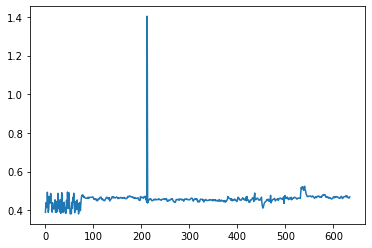

In [534]:
df=pd.read_csv('BANKS/m2_s2_bank_0053979e93612348a180e1133103725e__site_0d39d11b52565146a236a646d49133f4.csv')
df=df[df['CellNo']==60].reset_index(drop=True)
df['ResistValue'].plot()

<AxesSubplot:>

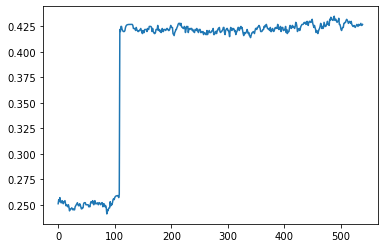

In [524]:
df=pd.read_csv('cell_1_1_adjv2.csv')
df=df['ResistValue']
df.plot()